In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
import subprocess
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.backend import random_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_probability as tfp

In [6]:
# Load data
data = np.load('../FER_plus.npz', allow_pickle=True)

# Unpack datasets
X_train = data['xtrain'][:, np.newaxis].astype(np.float) * 1./255
Y_train = data['ytrain']
print('Train: {}'.format(X_train.shape[0]))

X_val = data['xvalid'][:, np.newaxis].astype(np.float) * 1./255
Y_val = data['yvalid']
print('Validation: {}'.format(X_val.shape[0]))

X_test = data['xtest'][:, np.newaxis].astype(np.float) * 1./255
Y_test = data['ytest']
print('Test: {}'.format(X_test.shape[0]))

labels = data['labels']

Train: 28709
Validation: 3589
Test: 3589


## Baseline CNN

In [5]:
model = Sequential()
model.add(Input(shape=(48,48,1)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9

In [34]:
# Trained up to 100 epochs
model.fit(train_generator, validation_data=val_generator, epochs=70)

Epoch 1/70
773/773 [==============================] - 26s 34ms/step - loss: 1.2376 - accuracy: 0.5249 - val_loss: 1.2529 - val_accuracy: 0.5153
Epoch 2/70
773/773 [==============================] - 28s 37ms/step - loss: 1.2261 - accuracy: 0.5343 - val_loss: 1.2359 - val_accuracy: 0.5253
Epoch 3/70
773/773 [==============================] - 29s 37ms/step - loss: 1.2310 - accuracy: 0.5328 - val_loss: 1.2671 - val_accuracy: 0.5132
Epoch 4/70
773/773 [==============================] - 30s 39ms/step - loss: 1.2275 - accuracy: 0.5274 - val_loss: 1.2543 - val_accuracy: 0.5173
Epoch 5/70
773/773 [==============================] - 31s 40ms/step - loss: 1.2139 - accuracy: 0.5383 - val_loss: 1.2438 - val_accuracy: 0.5228
Epoch 6/70
773/773 [==============================] - 32s 41ms/step - loss: 1.2149 - accuracy: 0.5375 - val_loss: 1.2443 - val_accuracy: 0.5272
Epoch 7/70
773/773 [==============================] - 31s 40ms/step - loss: 1.2134 - accuracy: 0.5410 - val_loss: 1.2415 - val_accuracy:

## Basic Autoencoder

In [43]:
# TODO: Separate out the encoder and decoder so the encoder can be used
# for downstream tasks

autoencoder = Sequential()

# Encoder
autoencoder.add(Input(shape=(48,48,1)))
autoencoder.add(Conv2D(16, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2)))
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2)))
autoencoder.add(Conv2D(64, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(2,2))

# Decoder
autoencoder.add(Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer=Adam(), loss=tf.keras.losses.mae)

autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 12, 12, 64)       

In [60]:
# Trained up to 50 epochs
autoencoder.fit(train_generator, validation_data=val_generator, epochs=45)

Epoch 1/45
773/773 [==============================] - 44s 56ms/step - loss: 0.0466 - val_loss: 0.0464
Epoch 2/45
773/773 [==============================] - 44s 57ms/step - loss: 0.0455 - val_loss: 0.0455
Epoch 3/45
773/773 [==============================] - 46s 59ms/step - loss: 0.0444 - val_loss: 0.0440
Epoch 4/45
773/773 [==============================] - 47s 61ms/step - loss: 0.0436 - val_loss: 0.0441
Epoch 5/45
773/773 [==============================] - 43s 56ms/step - loss: 0.0429 - val_loss: 0.0425
Epoch 6/45
773/773 [==============================] - 44s 57ms/step - loss: 0.0423 - val_loss: 0.0418
Epoch 7/45
773/773 [==============================] - 44s 56ms/step - loss: 0.0417 - val_loss: 0.0415
Epoch 8/45
773/773 [==============================] - 46s 59ms/step - loss: 0.0413 - val_loss: 0.0411
Epoch 9/45
773/773 [==============================] - 45s 58ms/step - loss: 0.0408 - val_loss: 0.0417
Epoch 10/45
773/773 [==============================] - 43s 56ms/step - loss: 0.040

(32, 48, 48, 1)
(48, 48, 1)


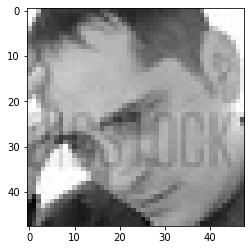

In [62]:
print(pred.shape)
print(ex[0][0].shape)
plt.imshow(ex[0][0], cmap='gray')

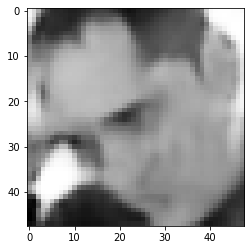

In [63]:
plt.imshow(pred[0], cmap='gray')

## VAE

In [92]:
# Functional API Version

latent_dims = 100

# Samples z given z_mean, z_log_var
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        latent_dims = tf.shape(z_mean)[1]
        
        # Reparameterization Trick
        epsilon = random_normal(shape=(batch_size, latent_dims))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
input_img = Input(shape=(48,48,1), name='encoder_input')
e = Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same')(input_img)
e = MaxPooling2D((2,2))(e)
e = Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(e)
e = MaxPooling2D((2,2))(e)
e = Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(e)
e = MaxPooling2D((2,2))(e)
e = Flatten()(e)
z_mean = Dense(latent_dims, name='z_mean')(e)
z_log_var = Dense(latent_dims, name='z_log_var')(e)
z = Sampling()((z_mean, z_log_var))

encoder = Model(inputs=input_img, outputs=z, name='encoder')

# Decoder
input_z = Input(shape=(latent_dims,), name='decoder_input')
d = Dense(6*6*64, activation='relu')(input_z)
d = Reshape(target_shape=(6,6,64))(d)
d = Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(d)
d = Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(d)
d = Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(d)
x = Conv2DTranspose(1, (3,3), activation='relu', padding='same')(d)

decoder = Model(inputs=input_z, outputs=x, name='decoder')

# VAE
output_img = decoder(z)
vae = Model(inputs=input_img, outputs=output_img, name='VAE')

# Define ELBO Loss
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# MSE Loss
# w = 24000 / 32 = 750
def scaled_mse(y_true, y_pred, w=750):
    return w * tf.keras.losses.mean_squared_error(y_true, y_pred)

vae.compile(optimizer=Adam(), loss=scaled_mse, metrics=[scaled_mse])
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 24, 24, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 12, 12, 16)   0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 6, 6, 32)     4640        max_pooling2d_35[0][0]           
________________________________________________________________________________________________

In [119]:
# Trained up to 200
vae.fit(train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100
773/773 [==============================] - 21s 28ms/step - loss: 8.5911 - scaled_mse: 7.5216 - val_loss: 9.4486 - val_scaled_mse: 8.3713
Epoch 2/100
773/773 [==============================] - 21s 27ms/step - loss: 8.5690 - scaled_mse: 7.4984 - val_loss: 9.3557 - val_scaled_mse: 8.2946
Epoch 3/100
773/773 [==============================] - 20s 26ms/step - loss: 8.5622 - scaled_mse: 7.4929 - val_loss: 9.4091 - val_scaled_mse: 8.3351
Epoch 4/100
773/773 [==============================] - 21s 27ms/step - loss: 8.5618 - scaled_mse: 7.4922 - val_loss: 9.3353 - val_scaled_mse: 8.2645
Epoch 5/100
773/773 [==============================] - 21s 27ms/step - loss: 8.5564 - scaled_mse: 7.4871 - val_loss: 9.5332 - val_scaled_mse: 8.4790
Epoch 6/100
773/773 [==============================] - 21s 27ms/step - loss: 8.5477 - scaled_mse: 7.4795 - val_loss: 9.3580 - val_scaled_mse: 8.2902
Epoch 7/100
773/773 [==============================] - 21s 27ms/step - loss: 8.5481 - scaled_mse: 7.4801 -

Epoch 56/100
773/773 [==============================] - 20s 26ms/step - loss: 8.3985 - scaled_mse: 7.3331 - val_loss: 9.3688 - val_scaled_mse: 8.3032
Epoch 57/100
773/773 [==============================] - 21s 27ms/step - loss: 8.3911 - scaled_mse: 7.3253 - val_loss: 9.3850 - val_scaled_mse: 8.3208
Epoch 58/100
773/773 [==============================] - 20s 26ms/step - loss: 8.3839 - scaled_mse: 7.3182 - val_loss: 9.3788 - val_scaled_mse: 8.3159
Epoch 59/100
773/773 [==============================] - 22s 28ms/step - loss: 8.3901 - scaled_mse: 7.3230 - val_loss: 9.4345 - val_scaled_mse: 8.3718
Epoch 60/100
773/773 [==============================] - 21s 27ms/step - loss: 8.3848 - scaled_mse: 7.3193 - val_loss: 9.3463 - val_scaled_mse: 8.2819
Epoch 61/100
773/773 [==============================] - 21s 27ms/step - loss: 8.3799 - scaled_mse: 7.3135 - val_loss: 9.3525 - val_scaled_mse: 8.2792
Epoch 62/100
773/773 [==============================] - 21s 27ms/step - loss: 8.3887 - scaled_mse: 7

In [120]:
pred = vae.predict(ex[0])

(32, 48, 48, 1)
(48, 48, 1)


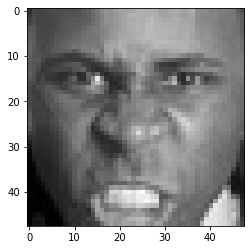

In [144]:
print(pred.shape)
print(ex[0][0].shape)
plt.imshow(ex[0][], cmap='gray')

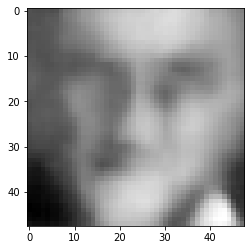

In [145]:
plt.imshow(pred[7], cmap='gray')

## Beta-VAE

In [131]:
# Functional API Version

latent_dims = 100

# Samples z given z_mean, z_log_var
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        latent_dims = tf.shape(z_mean)[1]
        
        # Reparameterization Trick
        epsilon = random_normal(shape=(batch_size, latent_dims))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
input_img = Input(shape=(48,48,1), name='encoder_input')
e = Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same')(input_img)
e = MaxPooling2D((2,2))(e)
e = Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(e)
e = MaxPooling2D((2,2))(e)
e = Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(e)
e = MaxPooling2D((2,2))(e)
e = Flatten()(e)
z_mean = Dense(latent_dims, name='z_mean')(e)
z_log_var = Dense(latent_dims, name='z_log_var')(e)
z = Sampling()((z_mean, z_log_var))

beta_encoder = Model(inputs=input_img, outputs=z, name='encoder')

# Decoder
input_z = Input(shape=(latent_dims,), name='decoder_input')
d = Dense(6*6*64, activation='relu')(input_z)
d = Reshape(target_shape=(6,6,64))(d)
d = Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(d)
d = Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(d)
d = Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(d)
x = Conv2DTranspose(1, (3,3), activation='relu', padding='same')(d)

beta_decoder = Model(inputs=input_z, outputs=x, name='decoder')

# VAE
output_img = decoder(z)
beta_vae = Model(inputs=input_img, outputs=output_img, name='Beta-VAE')

# Define ELBO Loss (Where to add Beta? And how?)
beta = 3
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1) * beta
beta_vae.add_loss(kl_loss)

# MSE Loss
# w = 24000 / 32 = 750
def scaled_mse(y_true, y_pred, w=750):
    return w * tf.keras.losses.mean_squared_error(y_true, y_pred)

beta_vae.compile(optimizer=Adam(), loss=scaled_mse, metrics=[scaled_mse])
beta_vae.summary()

Model: "Beta-VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 24, 24, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 12, 12, 16)   0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 6, 6, 32)     4640        max_pooling2d_41[0][0]           
___________________________________________________________________________________________

In [132]:
beta_vae.fit(train_generator, validation_data=val_generator, epochs=300)

Epoch 1/300
773/773 [==============================] - 21s 28ms/step - loss: 24.1549 - scaled_mse: 22.7499 - val_loss: 18.3378 - val_scaled_mse: 16.8733
Epoch 2/300
773/773 [==============================] - 21s 27ms/step - loss: 16.8891 - scaled_mse: 15.3681 - val_loss: 16.0828 - val_scaled_mse: 14.5392
Epoch 3/300
773/773 [==============================] - 21s 27ms/step - loss: 15.3454 - scaled_mse: 13.7903 - val_loss: 14.8921 - val_scaled_mse: 13.3141
Epoch 4/300
773/773 [==============================] - 21s 28ms/step - loss: 14.4072 - scaled_mse: 12.8043 - val_loss: 14.2052 - val_scaled_mse: 12.5724
Epoch 5/300
773/773 [==============================] - 21s 28ms/step - loss: 13.8431 - scaled_mse: 12.2151 - val_loss: 13.8087 - val_scaled_mse: 12.1920
Epoch 6/300
773/773 [==============================] - 22s 28ms/step - loss: 13.4582 - scaled_mse: 11.8144 - val_loss: 13.4934 - val_scaled_mse: 11.8006
Epoch 7/300
773/773 [==============================] - 20s 26ms/step - loss: 13.15

Epoch 55/300
773/773 [==============================] - 20s 26ms/step - loss: 10.4731 - scaled_mse: 8.4464 - val_loss: 11.1270 - val_scaled_mse: 9.1162
Epoch 56/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4614 - scaled_mse: 8.4334 - val_loss: 11.1343 - val_scaled_mse: 9.1099
Epoch 57/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4406 - scaled_mse: 8.4105 - val_loss: 11.1018 - val_scaled_mse: 9.0879
Epoch 58/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4319 - scaled_mse: 8.4019 - val_loss: 11.0380 - val_scaled_mse: 9.0404
Epoch 59/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4264 - scaled_mse: 8.3934 - val_loss: 11.1139 - val_scaled_mse: 9.0869
Epoch 60/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4167 - scaled_mse: 8.3822 - val_loss: 11.0378 - val_scaled_mse: 9.0102
Epoch 61/300
773/773 [==============================] - 21s 27ms/step - loss: 10.4067 - 

Epoch 109/300
773/773 [==============================] - 21s 27ms/step - loss: 10.1231 - scaled_mse: 8.0118 - val_loss: 10.8660 - val_scaled_mse: 8.7713
Epoch 110/300
773/773 [==============================] - 20s 26ms/step - loss: 10.1176 - scaled_mse: 8.0063 - val_loss: 10.8710 - val_scaled_mse: 8.7489
Epoch 111/300
773/773 [==============================] - 20s 26ms/step - loss: 10.1124 - scaled_mse: 8.0009 - val_loss: 10.8825 - val_scaled_mse: 8.7647
Epoch 112/300
773/773 [==============================] - 21s 27ms/step - loss: 10.1072 - scaled_mse: 7.9938 - val_loss: 10.8364 - val_scaled_mse: 8.7261
Epoch 113/300
773/773 [==============================] - 21s 27ms/step - loss: 10.1060 - scaled_mse: 7.9905 - val_loss: 10.8573 - val_scaled_mse: 8.7520
Epoch 114/300
773/773 [==============================] - 21s 27ms/step - loss: 10.0955 - scaled_mse: 7.9802 - val_loss: 10.9433 - val_scaled_mse: 8.8264
Epoch 115/300
773/773 [==============================] - 21s 27ms/step - loss: 10.

Epoch 216/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8934 - scaled_mse: 7.7212 - val_loss: 10.7982 - val_scaled_mse: 8.6363
Epoch 217/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8820 - scaled_mse: 7.7119 - val_loss: 10.7553 - val_scaled_mse: 8.5730
Epoch 218/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8862 - scaled_mse: 7.7142 - val_loss: 10.8491 - val_scaled_mse: 8.6217
Epoch 219/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8901 - scaled_mse: 7.7144 - val_loss: 10.7971 - val_scaled_mse: 8.5864
Epoch 220/300
773/773 [==============================] - 23s 29ms/step - loss: 9.8874 - scaled_mse: 7.7134 - val_loss: 10.7469 - val_scaled_mse: 8.5774
Epoch 221/300
773/773 [==============================] - 23s 29ms/step - loss: 9.8769 - scaled_mse: 7.7027 - val_loss: 10.7298 - val_scaled_mse: 8.5630
Epoch 222/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8817 - 

Epoch 270/300
773/773 [==============================] - 23s 29ms/step - loss: 9.8407 - scaled_mse: 7.6550 - val_loss: 10.7117 - val_scaled_mse: 8.5271
Epoch 271/300
773/773 [==============================] - 23s 29ms/step - loss: 9.8405 - scaled_mse: 7.6589 - val_loss: 10.7246 - val_scaled_mse: 8.5132
Epoch 272/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8310 - scaled_mse: 7.6472 - val_loss: 10.7493 - val_scaled_mse: 8.5734
Epoch 273/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8392 - scaled_mse: 7.6550 - val_loss: 10.7438 - val_scaled_mse: 8.5209
Epoch 274/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8289 - scaled_mse: 7.6451 - val_loss: 10.7822 - val_scaled_mse: 8.6348
Epoch 275/300
773/773 [==============================] - 22s 29ms/step - loss: 9.8375 - scaled_mse: 7.6521 - val_loss: 10.7339 - val_scaled_mse: 8.5421
Epoch 276/300
773/773 [==============================] - 22s 28ms/step - loss: 9.8292 - 